In [2]:
# Import Library
#!pip install torchtext spacy
import random
import torch, torchtext

from torchtext.legacy import data

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [100]:
import pandas as pd
df_train = pd.read_csv('dataset/train.csv')
print("Length of Train dataset: ",len(df_train))
df_test= pd.read_csv('dataset/test.csv')
print("Length of Test dataset: ",len(df_test))

Length of Train dataset:  8117
Length of Test dataset:  3168


In [101]:
df_train["sentence"]=df_train["sentence"].astype(str)
df_train["sentiment_cls_value"] = df_train["sentiment_cls_value"].astype(int)
df_test["sentence"]=df_test["sentence"].astype(str)
df_test["sentiment_cls_value"] = df_test["sentiment_cls_value"].astype(int)

In [102]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.7 MB 32.4 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [104]:
Sentence = data.Field(sequential = True, tokenize = 'spacy', tokenizer_language= "en_core_web_sm",batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize='spacy', is_target=True, batch_first =True, sequential =False)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [105]:
fields = [('sentence', Sentence),('sentiment_cls_value',Label)]

In [106]:
example = [data.Example.fromlist([df_train.sentence[i],df_train.sentiment_cls_value[i]], fields) for i in range(df_train.shape[0])] 
train_dataset = data.Dataset(example, fields)
example = [data.Example.fromlist([df_test.sentence[i],df_test.sentiment_cls_value[i]], fields) for i in range(df_test.shape[0])] 
test_dataset = data.Dataset(example, fields)

In [107]:
import os, pickle

Sentence.build_vocab(train_dataset, max_size = 25000, vectors = "glove.6B.300d")
Label.build_vocab(train_dataset)

In [108]:
print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  16494
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 7635), (',', 6706), ('the', 5714), ('of', 4170), ('and', 4153), ('a', 4147), ('to', 2844), ('-', 2624), ('is', 2403), ("'s", 2353)]
Labels :  defaultdict(None, {3: 0, 1: 1, 2: 2, 4: 3, 0: 4})


In [109]:
import os, pickle
with open('pickle_files/train_tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Sentence.vocab.stoi, tokens)

In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_iterator = data.BucketIterator(train_dataset, batch_size = 32, 
                                                            sort_key = lambda x: len(x.sentence),
                                                            sort_within_batch=True, device = device)


In [112]:
Sentence.build_vocab(test_dataset, max_size = 25000, vectors = "glove.6B.300d")
Label.build_vocab(test_dataset)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_iterator = data.BucketIterator(test_dataset, batch_size = 32, 
                                                            sort_key = lambda x: len(x.sentence),
                                                            sort_within_batch=True, device = device)

with open('pickle_files/test_tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Sentence.vocab.stoi, tokens)

print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  10180
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 2995), (',', 2669), ('the', 2254), ('and', 1626), ('a', 1615), ('of', 1605), ('to', 1156), ('-', 1059), ('is', 940), ("'s", 938)]
Labels :  defaultdict(None, {1: 0, 3: 1, 2: 2, 4: 3, 0: 4})


In [113]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx= pad_idx)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                               hidden_dim, 
                               num_layers=n_layers, 
                               dropout=dropout,
                               bidirectional=True,
                               batch_first=True,
                               bias=True)
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        #packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [114]:
# Define hyperparameters
size_of_vocab = len(Sentence.vocab)
embedding_dim = 300
num_hidden_nodes = 256
num_output_nodes = 5
num_layers = 5
dropout = 0.65
pad_idx = Sentence.vocab.stoi[Sentence.pad_token]

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [115]:
print(model)

#No. of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(10180, 300, padding_idx=1)
  (encoder): LSTM(300, 256, num_layers=5, batch_first=True, dropout=0.65, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.65, inplace=False)
)
The model has 10,505,909 trainable parameters


In [116]:
pretrained_embeddings = Sentence.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1256,  0.0136,  0.1031,  ..., -0.3422, -0.0224,  0.1368],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0202, -0.2257,  0.0055,  ...,  0.4262,  0.2258,  0.2486],
        [ 0.0206, -0.2081,  0.4568,  ...,  0.4254,  0.2714, -0.1388]])

In [117]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [118]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.sentence   
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()  
        
        # compute the loss
        #print("train",len(predictions),len(batch.sentiment_cls_value))
        loss = criterion(predictions, batch.sentiment_cls_value)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.sentiment_cls_value)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [119]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            
            # compute loss and accuracy
            #print(sentence.size(),len(predictions),len(batch.sentiment_cls_value))
            loss = criterion(predictions, batch.sentiment_cls_value)
            acc = binary_accuracy(predictions, batch.sentiment_cls_value)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [123]:
import time
N_EPOCHS = 10
best_test_loss = float('inf')
train_losses = []
test_losses = []

train_accuracy = []
test_accuracy = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    # evaluate the model
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)


    # save the best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'weights/saved_weights.pt')
    
    print(f'Epoch {epoch+1} | Time Taken: {(time.time() - start_time):.2f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}% \n')
     

Epoch 1 | Time Taken: 5.81s
	Train Loss: 1.499 | Train Acc: 39.70%
	 Val. Loss: 1.520 |  Val. Acc: 36.55% 

Epoch 2 | Time Taken: 5.83s
	Train Loss: 1.479 | Train Acc: 41.56%
	 Val. Loss: 1.490 |  Val. Acc: 39.90% 

Epoch 3 | Time Taken: 5.78s
	Train Loss: 1.459 | Train Acc: 43.60%
	 Val. Loss: 1.479 |  Val. Acc: 41.16% 

Epoch 4 | Time Taken: 5.58s
	Train Loss: 1.445 | Train Acc: 45.49%
	 Val. Loss: 1.499 |  Val. Acc: 39.30% 

Epoch 5 | Time Taken: 5.77s
	Train Loss: 1.433 | Train Acc: 46.61%
	 Val. Loss: 1.468 |  Val. Acc: 42.27% 

Epoch 6 | Time Taken: 5.56s
	Train Loss: 1.415 | Train Acc: 48.46%
	 Val. Loss: 1.470 |  Val. Acc: 41.86% 

Epoch 7 | Time Taken: 5.58s
	Train Loss: 1.402 | Train Acc: 49.95%
	 Val. Loss: 1.472 |  Val. Acc: 41.60% 

Epoch 8 | Time Taken: 5.57s
	Train Loss: 1.386 | Train Acc: 51.98%
	 Val. Loss: 1.469 |  Val. Acc: 42.42% 

Epoch 9 | Time Taken: 5.58s
	Train Loss: 1.370 | Train Acc: 53.96%
	 Val. Loss: 1.475 |  Val. Acc: 41.16% 

Epoch 10 | Time Taken: 5.57s

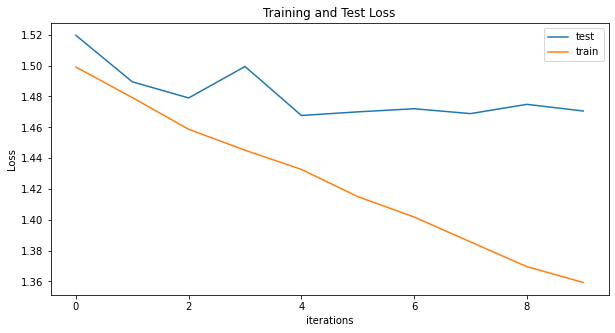

In [127]:
import matplotlib.pyplot  as plt
# Plotting the train and test loss

plt.figure(figsize=(10,5))
plt.title("Training and Test Loss")
plt.plot(test_losses,label="test")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

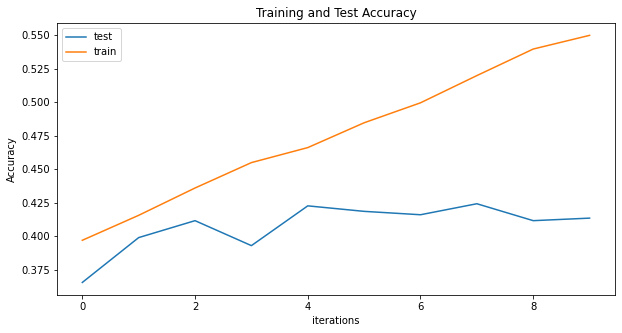

In [128]:
# Plotting the train and validation Accuracy

plt.figure(figsize=(10,5))
plt.title("Training and Test Accuracy")
plt.plot(test_accuracy,label="test")
plt.plot(train_accuracy,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [130]:
#load weights and tokenizer

path='weights/saved_weights.pt'
model.load_state_dict(torch.load(path))
model.eval();
tokenizer_file = open('pickle_files/test_tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en_core_web_sm')

def classify_review(text):
    
    categories = {0: "Very Negative", 1:"Negative", 2:"Neutral", 3:"Positive", 4:"Very Positive" }
    
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(text)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [131]:
import time
start_time = time.time()
sentiment = classify_review("""With a story inspired by the tumultuous surroundings of Los Angeles , 
                where feelings of marginalization loom for every dreamer with a burst bubble ,
                The Dogwalker has a few characters and ideas , 
                but it never manages to put them on the same path .""")
print("Time taken: ", time.time()-start_time)
print(sentiment)

Time taken:  0.009605169296264648
Negative


In [133]:
categories = {0: "Very Negative", 1:"Negative", 2:"Neutral", 3:"Positive", 4:"Very Positive" }

In [135]:
df_test["Predicted_Sentiment"] = df_test["sentence"].apply(lambda x: classify_review(x))
df_test["Predicted_Label"] = df_test["Predicted_Sentiment"].apply(lambda x: [k for k,v in categories.items() if v == x][0])

In [136]:
df_test.to_csv("dataset/test_predicted.csv")

In [138]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
display(df_test[['sentence','sentiment_class','Predicted_Sentiment','sentiment_cls_value','Predicted_Label']].head(n=10))

,sentence,sentiment_class,Predicted_Sentiment,sentiment_cls_value,Predicted_Label
0,Effective but too-tepid biopic,Neutral,Very Negative,2,0
1,"If you sometimes like to go to the movies to have fun , Wasabi is a good place to start .",Positive,Negative,3,1
2,"Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one .",Very_Positive,Negative,4,1
3,The film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .,Neutral,Negative,2,1
4,Offers that rare combination of entertainment and education .,Very_Positive,Positive,4,3
5,Perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .,Positive,Negative,3,1
6,Steers turns in a snappy screenplay that curls at the edges ; it 's so clever you want to hate it .,Positive,Negative,3,1
7,But he somehow pulls it off .,Positive,Very Negative,3,0
8,Take Care of My Cat offers a refreshingly different slice of Asian cinema .,Positive,Positive,3,3
9,"This is a film well worth seeing , talking and singing heads and all .",Very_Positive,Positive,4,3


In [140]:
df_test_results_correct =  df_test[df_test["sentiment_class"]==df_test["Predicted_Sentiment"]].sample(25)
df_test_results_correct[['sentence','sentiment_class','Predicted_Sentiment']]

,sentence,sentiment_class,Predicted_Sentiment
322,"Clever , brutal and strangely soulful movie .",Positive,Positive
3096,Punish the vehicle to adore the star .,Negative,Negative
787,"A work of intricate elegance , literary lyricism and profound common sense .",Positive,Positive
519,"For the first two-thirds of this sparklingly inventive and artful , always fast and furious tale , kids will go happily along for the ride .",Positive,Positive
1660,Over age 15 ?,Neutral,Neutral
3042,"As your relatives swap one mundane story after another , you begin to wonder if they are ever going to depart .",Negative,Negative
343,"Audiences conditioned to getting weepy over saucer-eyed , downy-cheeked moppets and their empathetic caretakers will probably feel emotionally cheated by the film 's tart , sugar-free wit .",Negative,Negative
2018,A solid film ... but more conscientious than it is truly stirring .,Positive,Positive
624,"As adapted by Kevin Molony from Simon Leys ' novel `` The Death of Napoleon '' and directed by Alan Taylor , Napoleon 's journey is interesting but his Parisian rebirth is stillborn",Negative,Negative
2640,"Reggio 's trippy , ambitious downer can also sometimes come across like nothing more than a glorified Nike ad .",Negative,Negative


In [142]:
df_test_false_positives =  df_test.query('sentiment_class in ["Negative","Very Negative"] and Predicted_Sentiment in ["Positive","Very Positive","Neutral"]')
df_test_false_positives[['sentence','sentiment_class','Predicted_Sentiment']].sample(25)


,sentence,sentiment_class,Predicted_Sentiment
1960,But what are adults doing in the theater at all ?,Negative,Neutral
3030,"Safe Conduct , however ambitious and well-intentioned , fails to hit the entertainment bull 's - eye .",Negative,Neutral
2543,A great idea becomes a not-great movie .,Negative,Neutral
261,Has it ever been possible to say that Williams has truly inhabited a character ?,Negative,Neutral
2118,"I doubt anyone will remember the picture by the time Christmas really rolls around , but maybe it 'll be on video by then .",Negative,Neutral
2986,Here 's a self-congratulatory 3D IMAX rah-rah .,Negative,Neutral
2432,"Considering the harsh locations and demanding stunts , this must have been a difficult shoot , but the movie proves rough going for the audience as well .",Negative,Neutral
2027,Hit and miss as far as the comedy goes and a big ole ' miss in the way of story .,Negative,Neutral
1886,"Its story may be a thousand years old , but why did it have to seem like it took another thousand to tell it to us ?",Negative,Neutral
2498,What happened with Pluto Nash ?,Negative,Neutral


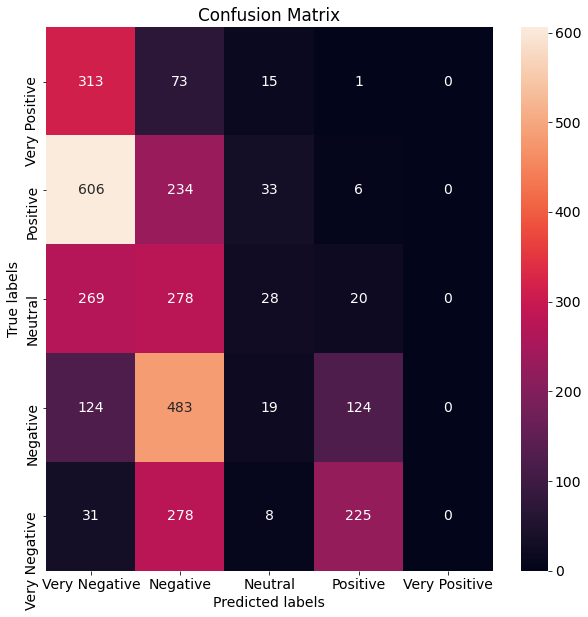

In [145]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_test['sentiment_cls_value'].values, df_test['Predicted_Label'].values)

import seaborn as sns
import matplotlib.pyplot as plt     


font = {'font.size': 14}
plt.rcParams.update(font)
plt.figure(figsize=(10, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(categories.values())); ax.yaxis.set_ticklabels(list(categories.values())[::-1]);



In [147]:
df_test.sentiment_cls_value.value_counts()

1    879
3    750
2    595
4    542
0    402
Name: sentiment_cls_value, dtype: int64